In [20]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [21]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join

In [22]:
torch.cuda.set_device(0)
torch.cuda.current_device()

0

In [23]:
data_dir = Path('data')
colombia_rural = Path('data/stac/colombia/borde_rural')
colombia_soacha = Path('data/stac/colombia/borde_soacha')

In [24]:
guatemala_mixco1 = Path('data/stac/guatemala/mixco_1_and_ebenezer')
guatemala_mixco3 = Path('data/stac/guatemala/mixco_3')

In [25]:
st_lucia_castries = Path('data/stac/st_lucia/castries')
st_lucia_dennery = Path('data/stac/st_lucia/dennery')
st_lucia_gros_islet = Path('data/stac/st_lucia/gros_islet')

In [26]:
COUNTRY='colombia'
REGION='borde_rural'
DATASET = f'{COUNTRY}_{REGION}'
DATASET_PATH=colombia_rural
path=data_dir/f'{COUNTRY}_{REGION}/cropped/'
TRAIN_JSON = f'train-{REGION}.geojson'
TEST_JSON = f'test-{REGION}.geojson'

In [27]:
RESIZE_IMAGES = True

In [28]:
MODEL_NAME='cv_reflect_101'

In [29]:
NB_NUM='09_8'

In [30]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: 0cd2941b, DATE: 20191128


In [31]:
DATE = '20191123'
UID = 'faa28d68'

In [32]:
SUB_NUM='2'

In [33]:
img_size=256

In [34]:
train_images=data_dir/f'train/rotated/clipped/{img_size}'
test_images=data_dir/f'test/rotated/clipped/{img_size}'

In [35]:
test_names = get_image_files(test_images)

In [36]:
assert len(test_names)==7325

In [37]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [38]:
df_all.tail()

,id,roof_material,verified,country,region
22548,7a22ddec,healthy_metal,False,st_lucia,gros_islet
22549,7a2f73ea,healthy_metal,False,st_lucia,gros_islet
22550,7a34ffa4,healthy_metal,False,st_lucia,gros_islet
22551,7a41560a,healthy_metal,False,st_lucia,gros_islet
22552,7a283ad0,healthy_metal,False,st_lucia,gros_islet


In [39]:
#### add multiclass column

In [40]:
df_all['target']=df_all['roof_material']+' '+df_all['region']

In [41]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [42]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [43]:
assert len(df_test)==7325

In [44]:
df_all.loc[df_all['id'] == '7a204ec4']

,id,roof_material,verified,country,region,target
12960,7a204ec4,irregular_metal,True,guatemala,mixco_1_and_ebenezer,irregular_metal mixco_1_and_ebenezer


In [45]:
len(df_all)

22553

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [46]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [47]:
np.random.seed(42)
dep_var='target'
src = (ImageList.from_df(path=train_images, df=df_all, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var, label_delim=' ')
      .add_test_folder(test_images))

22553


In [48]:
data = (src.transform(tfms, size=img_size)
        .databunch().normalize(imagenet_stats))

In [49]:
#to check what params object has
#dir(data)

In [50]:
data.label_list

LabelLists;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
concrete_cement;borde_rural,irregular_metal;borde_rural,healthy_metal;borde_rural,healthy_metal;borde_rural,healthy_metal;borde_rural
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
irregular_metal;mixco_1_and_ebenezer,healthy_metal;castries,healthy_metal;borde_soacha,irregular_metal;borde_soacha,healthy_metal;castries
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256

In [51]:
data.loss_func

FlattenedLoss of BCEWithLogitsLoss()

`show_batch` still works, and show us the different labels separated by `;`.

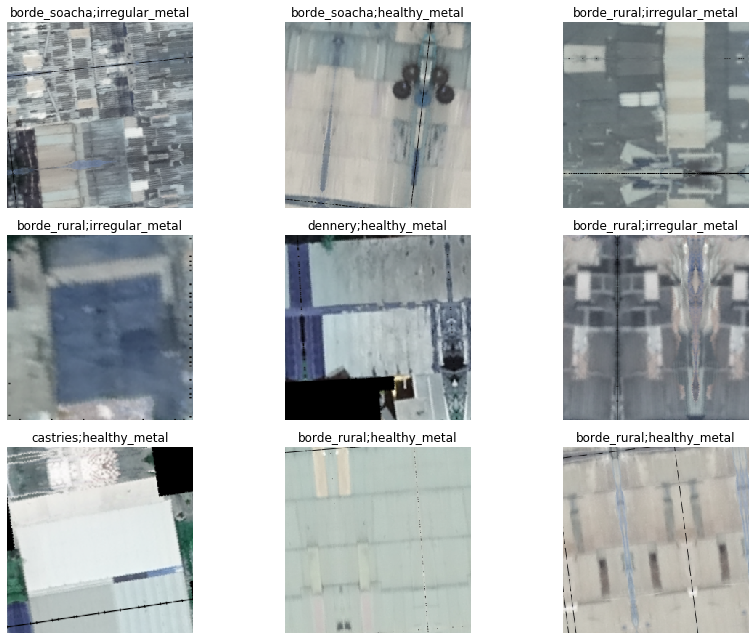

In [52]:
data.show_batch(rows=3, figsize=(12,9))

### Model

In [53]:
arch = models.resnet50
arch_name = 'rn50'

In [54]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

In [55]:
learn = cnn_learner(data, arch, metrics=[acc_02, f_score], bn_final=True)

In [37]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

We use the LR Finder to pick a good learning rate.

### Train model

In [38]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


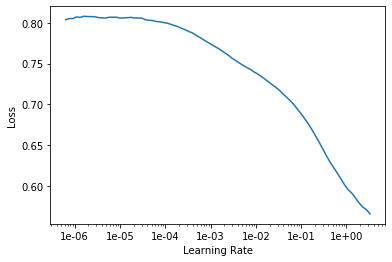

In [39]:
learn.recorder.plot()

Then we can fit the head of our network.

In [40]:
lr = 5e-2

In [41]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.229270,0.198958,0.901386,0.849222,01:13
1,0.154227,0.147602,0.920436,0.870313,01:14
2,0.137913,0.167406,0.923725,0.852942,01:19
3,0.122428,0.106789,0.946341,0.905705,01:25
4,0.113393,0.105408,0.948300,0.907317,01:22


In [42]:
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [43]:
learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')


In [44]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.121294,0.126669,0.944900,0.902423,01:21
1,0.134057,0.147393,0.926275,0.856009,01:19
2,0.126927,0.120414,0.940835,0.892830,01:17
3,0.113828,0.103742,0.949224,0.907673,01:14
4,0.104649,0.098683,0.951534,0.913033,01:13


In [45]:
learn.save(f'stage-1-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

#### Load model

In [46]:
learn.load(f'stage-1-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
concrete_cement;borde_rural,irregular_metal;borde_rural,healthy_metal;borde_rural,healthy_metal;borde_rural,healthy_metal;borde_rural
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
irregular_metal;mixco_1_and_ebenezer,healthy_metal;castries,healthy_metal;borde_soacha,irregular_metal;borde_soacha,healthy_metal;castries
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [48]:
learn.data.classes

['borde_rural',
 'borde_soacha',
 'castries',
 'concrete_cement',
 'dennery',
 'gros_islet',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'mixco_1_and_ebenezer',
 'mixco_3',
 'other']

In [49]:
#interp = ClassificationInterpretation.from_learner(learn)
#interp.most_confused(min_val=2)

In [50]:
#interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [51]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


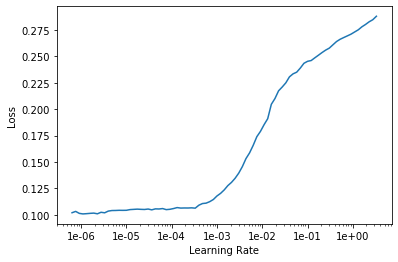

In [52]:
learn.lr_find()
learn.recorder.plot()

In [53]:
learn.fit_one_cycle(5, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.115834,0.110312,0.944161,0.901289,01:33
1,0.110832,0.106153,0.946268,0.905914,01:36
2,0.106316,0.098668,0.950850,0.912348,01:35
3,0.093955,0.093349,0.954102,0.916940,01:37
4,0.087684,0.091710,0.955488,0.920147,01:42


In [54]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [55]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
concrete_cement;borde_rural,irregular_metal;borde_rural,healthy_metal;borde_rural,healthy_metal;borde_rural,healthy_metal;borde_rural
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
irregular_metal;mixco_1_and_ebenezer,healthy_metal;castries,healthy_metal;borde_soacha,irregular_metal;borde_soacha,healthy_metal;castries
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [56]:
learn.fit_one_cycle(5, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.093314,0.102812,0.950314,0.907632,01:44
1,0.102792,0.101765,0.949002,0.908501,01:43
2,0.096422,0.094853,0.953529,0.916903,01:39
3,0.085572,0.090438,0.956430,0.919807,01:38
4,0.078059,0.089873,0.956911,0.920840,01:36


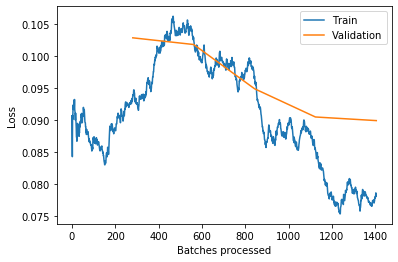

In [57]:
learn.recorder.plot_losses()

In [58]:
learn.save(f'stage-2-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [59]:
learn=learn.to_fp32()

In [60]:
learn.export(f'stage-2-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl')

In [61]:
learn.export()

### inference

In [56]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [57]:
len(test_dataset)

15325

In [58]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', file=f'stage-2-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl', test=test_dataset)

In [59]:
#learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', file=f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl', test=test_dataset)

In [60]:
learn.data.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [61]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [62]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

In [63]:
len(learn.dl(DatasetType.Test))

240

In [64]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [65]:
learn.data.c

12

In [66]:
learn.data.classes

['borde_rural',
 'borde_soacha',
 'castries',
 'concrete_cement',
 'dennery',
 'gros_islet',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'mixco_1_and_ebenezer',
 'mixco_3',
 'other']

In [67]:
preds.shape

torch.Size([15325, 12])

In [68]:
roof_indexes=[3,6,7,8,11]

In [69]:
roof_classes = np.array(learn.data.classes)
roof_classes=roof_classes[roof_indexes]

In [70]:
roof_preds = preds[:, roof_indexes]

In [71]:
labels = np.argmax(roof_preds, 1)

In [72]:
len(roof_preds)

15325

In [73]:
preds_list=[]
for pred in roof_preds:
    preds_list.append(pred.tolist())

In [74]:
test_predictions = [roof_classes[int(x)] for x in labels]

In [75]:
test_predictions[0]

'healthy_metal'

In [76]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [77]:
preds_list[0]

[0.06192722171545029,
 0.9429348707199097,
 0.000399990618461743,
 0.003707465948536992,
 0.0031740658450871706]

In [78]:
cols = list(roof_classes.copy())
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [79]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [80]:
df.head()

,id,pred
0,7a4d9168,"[0.06192722171545029, 0.9429348707199097, 0.00..."
1,7a4ae922,"[0.002024851506575942, 0.9620062708854675, 0.0..."
2,7a48ca98,"[0.007180273532867432, 0.16540665924549103, 0...."
3,7a49c614,"[0.0004822584451176226, 0.9157117009162903, 0...."
4,7a4dd4f2,"[0.0022570760920643806, 0.8471512794494629, 0...."


In [81]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [82]:
pred_df.insert(loc=0, column='id', value=ids)

In [83]:
pred_df.columns = cols

In [84]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.061927,0.942935,0.000400,0.003707,0.003174
1,7a4ae922,0.002025,0.962006,0.001764,0.038578,0.001850
2,7a48ca98,0.007180,0.165407,0.017814,0.763507,0.005652
3,7a49c614,0.000482,0.915712,0.001073,0.095951,0.003395
4,7a4dd4f2,0.002257,0.847151,0.001914,0.129171,0.012796


Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [85]:
pred_ids=pred_df['id'].values.tolist()

In [86]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [87]:
df_baseline.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.093275,0.496369,0.044923,0.352455,0.012979
1,7a4bbbd6,0.093275,0.496369,0.044923,0.352455,0.012979
2,7a4ac744,0.093275,0.496369,0.044923,0.352455,0.012979
3,7a4881fa,0.093275,0.496369,0.044923,0.352455,0.012979
4,7a4aa4a8,0.093275,0.496369,0.044923,0.352455,0.012979


In [88]:
baseline_ids=df_baseline['id'].values.tolist()

In [89]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [90]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [91]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
0,7a4d9168,0.061927,0.942935,0.000400,0.003707,0.003174,7a4d9168
1,7a4ae922,0.002025,0.962006,0.001764,0.038578,0.001850,7a4ae922
2,7a48ca98,0.007180,0.165407,0.017814,0.763507,0.005652,7a48ca98
3,7a49c614,0.000482,0.915712,0.001073,0.095951,0.003395,7a49c614
4,7a4dd4f2,0.002257,0.847151,0.001914,0.129171,0.012796,7a4dd4f2


In [92]:
pred_df=pred_df.sort_values('id_cat')

In [93]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
8041,7a4d630a,0.002840,0.991774,0.001295,0.006852,0.002052,7a4d630a
716,7a4d630a,0.002840,0.991774,0.001295,0.006852,0.002052,7a4d630a
764,7a4bbbd6,0.001554,0.969159,0.000506,0.040266,0.000915,7a4bbbd6
8089,7a4bbbd6,0.001554,0.969159,0.000506,0.040266,0.000915,7a4bbbd6
1841,7a4ac744,0.002303,0.302148,0.013190,0.643555,0.002847,7a4ac744


In [94]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [95]:
len(pred_df)

15325

In [96]:
pred_df=pred_df.drop_duplicates(subset=['id'])

In [97]:
len(pred_df)

7325

In [98]:
print(f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

submissions/stage-2-rn50-09_8-cv_reflect_101-20191123-faa28d68.csv


In [99]:
pred_df.to_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

In [103]:
### Submission 2: 0.4461


In [104]:
arch_name = 'rn50'
pred_df=pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

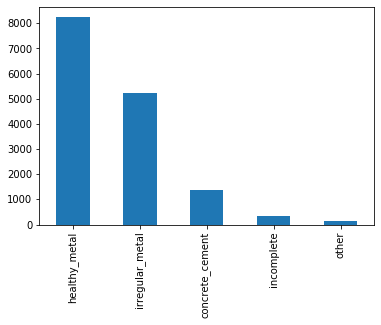

In [105]:
pred_df.drop(columns=['id'],inplace=True)
classes=pred_df.idxmax(axis=1)
pd.value_counts(classes).plot(kind="bar")